In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.
2.2.0


Using TensorFlow backend.


In [2]:
df=pd.read_csv("data_sin_tipocambio.csv")
#df=pd.read_csv("data_sin_varnula.csv")
#df=pd.read_csv("data_complete.csv")
df.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,BCHAIN-MKPRU (USD)
0,2015-01-15,43.80,3112.370,45.670,16872.95,1380.00,48.60,4.12,2013.750,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,218.11
1,2015-01-16,43.26,3147.530,45.730,16812.96,1404.90,46.35,4.12,1992.250,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,205.35
2,2015-01-17,43.26,3147.530,45.730,16812.96,1342.95,47.65,4.12,1992.250,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,197.12
3,2015-01-18,43.26,3178.075,45.730,16906.87,1281.00,48.95,4.12,1992.250,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,211.18
4,2015-01-19,44.13,3208.620,46.165,17000.78,1279.40,48.84,4.12,2006.505,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,212.39


In [3]:
df.shape

(2177, 16)

## Graficamos el historial del bitcoin desde el 2018 hasta la fecha

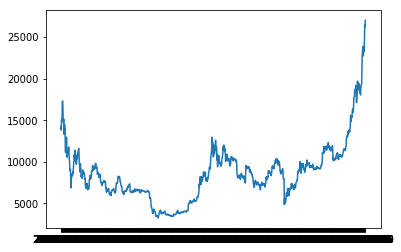

In [4]:
plt.plot(df.iloc[1082:,0], df.iloc[1082:,-1])

## Funcion para obtener ventanas a partir del dataframe 

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # shift
        # se utiliza para desplazar el índice de DataFrame por un número 
        # determinado de períodos con una frecuencia de tiempo opcional
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Definimos los  hiperparemetros y estandarizamos nuestros datos

In [6]:
ventana=3 # Se puede mover 
n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
entrenamiento=800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
n_obs=ventana*n_cols

In [7]:

values = df.iloc[1082:,1:].values# Desde el primer dia del 2018

transformer = StandardScaler()
transformer.fit(values)

transformer_y = StandardScaler()
transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

values = transformer.transform(values)
data = series_to_supervised(values, ventana,1 )

### Visualizamos el data frame de ventanas

In [8]:
data.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
3,1.161484,0.866946,-1.378602,0.528529,-1.038526,0.499388,0.477602,-0.718423,-1.813396,-0.066545,...,0.872874,0.035328,-0.974776,-1.802392,0.077947,4.423236,-1.540261,1.341660,3.707375,1.820202
4,1.161484,1.061030,-1.266617,0.672790,-0.380414,0.849897,0.860906,-0.496031,-1.809849,-0.034426,...,1.145881,-0.230036,-1.099826,-1.798572,0.079569,4.932414,-1.512628,1.359982,4.799380,1.861608
5,1.161484,0.275754,-1.222589,-0.219471,-0.565139,0.599867,0.035328,-0.849727,-1.805961,-0.044657,...,1.029824,-0.495401,-0.837567,-1.795321,0.088724,4.765112,-1.575431,1.045032,3.249554,2.421299
6,1.161484,0.500245,-0.998939,-0.040272,-0.564194,0.872874,0.035328,-0.974776,-1.802392,0.077947,...,1.082790,-0.672310,-0.658553,-1.791501,0.022579,5.696160,-1.512628,0.429209,3.256040,2.462417
7,1.161484,0.724736,-0.775289,0.138927,-0.563249,1.145881,-0.230036,-1.099826,-1.798572,0.079569,...,1.135755,-0.849220,-0.479539,-1.787818,-0.012308,5.159285,-1.527701,0.752450,3.450862,2.273169


### Creamos nuestro conjunto train y test con sus respectivos X y Y variables

In [9]:
train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(800, 45) (800,)
(292, 45) (292,)


### Modificamos las dimensiones del train y test para que tengan un formato:
(muestras, ventana, numero de variables)

In [10]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

## Creacion del modelo

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[train_X.shape[1],train_X.shape[2]]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(50,activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)

Epoch 1/1000
25/25 [==============================] - 3s 114ms/step - loss: 0.3489 - mae: 0.6994 - val_loss: 0.4322 - val_mae: 0.7322
Epoch 2/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.3505 - mae: 0.7040 - val_loss: 0.4321 - val_mae: 0.7319
Epoch 3/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.3478 - mae: 0.6972 - val_loss: 0.4320 - val_mae: 0.7316
Epoch 4/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.3441 - mae: 0.6941 - val_loss: 0.4319 - val_mae: 0.7313
Epoch 5/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.3412 - mae: 0.6919 - val_loss: 0.4318 - val_mae: 0.7310
Epoch 6/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.3367 - mae: 0.6867 - val_loss: 0.4317 - val_mae: 0.7307
Epoch 7/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.3369 - mae: 0.6821 - val_loss: 0.4316 - val_mae: 0.7304
Epoch 8/1000
25/25 [==============================] - 0s 9ms/step - lo

25/25 [==============================] - 0s 8ms/step - loss: 0.2554 - mae: 0.5783 - val_loss: 0.4287 - val_mae: 0.7217
Epoch 63/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2535 - mae: 0.5800 - val_loss: 0.4286 - val_mae: 0.7216
Epoch 64/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2577 - mae: 0.5846 - val_loss: 0.4286 - val_mae: 0.7215
Epoch 65/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2465 - mae: 0.5702 - val_loss: 0.4286 - val_mae: 0.7214
Epoch 66/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2493 - mae: 0.5746 - val_loss: 0.4285 - val_mae: 0.7213
Epoch 67/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2490 - mae: 0.5749 - val_loss: 0.4285 - val_mae: 0.7212
Epoch 68/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2490 - mae: 0.5732 - val_loss: 0.4285 - val_mae: 0.7212
Epoch 69/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2475 -

25/25 [==============================] - 0s 13ms/step - loss: 0.1916 - mae: 0.5029 - val_loss: 0.4269 - val_mae: 0.7198
Epoch 124/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1940 - mae: 0.5028 - val_loss: 0.4269 - val_mae: 0.7198
Epoch 125/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1839 - mae: 0.4887 - val_loss: 0.4269 - val_mae: 0.7198
Epoch 126/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1891 - mae: 0.4951 - val_loss: 0.4268 - val_mae: 0.7198
Epoch 127/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1911 - mae: 0.4991 - val_loss: 0.4268 - val_mae: 0.7199
Epoch 128/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1883 - mae: 0.4942 - val_loss: 0.4268 - val_mae: 0.7199
Epoch 129/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1844 - mae: 0.4918 - val_loss: 0.4268 - val_mae: 0.7200
Epoch 130/1000
25/25 [==============================] - 0s 8ms/step - loss: 

25/25 [==============================] - 0s 9ms/step - loss: 0.1405 - mae: 0.4308 - val_loss: 0.4245 - val_mae: 0.7181
Epoch 185/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1392 - mae: 0.4279 - val_loss: 0.4244 - val_mae: 0.7180
Epoch 186/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1454 - mae: 0.4336 - val_loss: 0.4244 - val_mae: 0.7180
Epoch 187/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.1454 - mae: 0.4323 - val_loss: 0.4243 - val_mae: 0.7179
Epoch 188/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1436 - mae: 0.4318 - val_loss: 0.4242 - val_mae: 0.7177
Epoch 189/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1447 - mae: 0.4364 - val_loss: 0.4241 - val_mae: 0.7177
Epoch 190/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.1411 - mae: 0.4307 - val_loss: 0.4241 - val_mae: 0.7176
Epoch 191/1000
25/25 [==============================] - 0s 8ms/step - loss:

25/25 [==============================] - 0s 9ms/step - loss: 0.1160 - mae: 0.3875 - val_loss: 0.4187 - val_mae: 0.7109
Epoch 246/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1135 - mae: 0.3802 - val_loss: 0.4186 - val_mae: 0.7108
Epoch 247/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1156 - mae: 0.3846 - val_loss: 0.4185 - val_mae: 0.7107
Epoch 248/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1132 - mae: 0.3800 - val_loss: 0.4184 - val_mae: 0.7106
Epoch 249/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.1144 - mae: 0.3755 - val_loss: 0.4183 - val_mae: 0.7105
Epoch 250/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.1138 - mae: 0.3802 - val_loss: 0.4182 - val_mae: 0.7104
Epoch 251/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1128 - mae: 0.3829 - val_loss: 0.4181 - val_mae: 0.7103
Epoch 252/1000
25/25 [==============================] - 0s 8ms/step - loss:

25/25 [==============================] - 0s 10ms/step - loss: 0.0924 - mae: 0.3396 - val_loss: 0.4108 - val_mae: 0.7041
Epoch 307/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0956 - mae: 0.3405 - val_loss: 0.4106 - val_mae: 0.7039
Epoch 308/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0910 - mae: 0.3361 - val_loss: 0.4105 - val_mae: 0.7038
Epoch 309/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0889 - mae: 0.3336 - val_loss: 0.4103 - val_mae: 0.7036
Epoch 310/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.0904 - mae: 0.3322 - val_loss: 0.4101 - val_mae: 0.7034
Epoch 311/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0930 - mae: 0.3383 - val_loss: 0.4100 - val_mae: 0.7032
Epoch 312/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0909 - mae: 0.3365 - val_loss: 0.4098 - val_mae: 0.7031
Epoch 313/1000
25/25 [==============================] - 0s 9ms/step - lo

25/25 [==============================] - 0s 8ms/step - loss: 0.0767 - mae: 0.3044 - val_loss: 0.4024 - val_mae: 0.6967
Epoch 368/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0758 - mae: 0.3030 - val_loss: 0.4023 - val_mae: 0.6965
Epoch 369/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0734 - mae: 0.2952 - val_loss: 0.4021 - val_mae: 0.6963
Epoch 370/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0757 - mae: 0.3029 - val_loss: 0.4019 - val_mae: 0.6961
Epoch 371/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0748 - mae: 0.3006 - val_loss: 0.4018 - val_mae: 0.6960
Epoch 372/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0761 - mae: 0.3012 - val_loss: 0.4016 - val_mae: 0.6957
Epoch 373/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0735 - mae: 0.2965 - val_loss: 0.4014 - val_mae: 0.6956
Epoch 374/1000
25/25 [==============================] - 0s 8ms/step - loss: 0

25/25 [==============================] - 0s 11ms/step - loss: 0.0639 - mae: 0.2780 - val_loss: 0.3951 - val_mae: 0.6909
Epoch 429/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0643 - mae: 0.2736 - val_loss: 0.3950 - val_mae: 0.6908
Epoch 430/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0637 - mae: 0.2734 - val_loss: 0.3948 - val_mae: 0.6906
Epoch 431/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0625 - mae: 0.2714 - val_loss: 0.3946 - val_mae: 0.6904
Epoch 432/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0643 - mae: 0.2754 - val_loss: 0.3945 - val_mae: 0.6904
Epoch 433/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0642 - mae: 0.2773 - val_loss: 0.3944 - val_mae: 0.6903
Epoch 434/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0616 - mae: 0.2715 - val_loss: 0.3943 - val_mae: 0.6901
Epoch 435/1000
25/25 [==============================] - 0s 8ms/step - loss: 

25/25 [==============================] - 0s 10ms/step - loss: 0.0569 - mae: 0.2584 - val_loss: 0.3876 - val_mae: 0.6851
Epoch 490/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0556 - mae: 0.2591 - val_loss: 0.3876 - val_mae: 0.6850
Epoch 491/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0528 - mae: 0.2513 - val_loss: 0.3875 - val_mae: 0.6850
Epoch 492/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0515 - mae: 0.2504 - val_loss: 0.3874 - val_mae: 0.6850
Epoch 493/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0544 - mae: 0.2550 - val_loss: 0.3873 - val_mae: 0.6848
Epoch 494/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0551 - mae: 0.2569 - val_loss: 0.3872 - val_mae: 0.6848
Epoch 495/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0542 - mae: 0.2536 - val_loss: 0.3870 - val_mae: 0.6846
Epoch 496/1000
25/25 [==============================] - 0s 14ms/step - loss:

25/25 [==============================] - 0s 9ms/step - loss: 0.0484 - mae: 0.2414 - val_loss: 0.3817 - val_mae: 0.6811
Epoch 551/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0483 - mae: 0.2423 - val_loss: 0.3816 - val_mae: 0.6811
Epoch 552/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0469 - mae: 0.2395 - val_loss: 0.3816 - val_mae: 0.6811
Epoch 553/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0499 - mae: 0.2455 - val_loss: 0.3814 - val_mae: 0.6809
Epoch 554/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0462 - mae: 0.2375 - val_loss: 0.3813 - val_mae: 0.6808
Epoch 555/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0497 - mae: 0.2421 - val_loss: 0.3811 - val_mae: 0.6806
Epoch 556/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0474 - mae: 0.2410 - val_loss: 0.3809 - val_mae: 0.6803
Epoch 557/1000
25/25 [==============================] - 0s 8ms/step - loss: 0

25/25 [==============================] - 0s 9ms/step - loss: 0.0426 - mae: 0.2238 - val_loss: 0.3762 - val_mae: 0.6773
Epoch 612/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0432 - mae: 0.2307 - val_loss: 0.3762 - val_mae: 0.6772
Epoch 613/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0444 - mae: 0.2324 - val_loss: 0.3762 - val_mae: 0.6773
Epoch 614/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0432 - mae: 0.2279 - val_loss: 0.3761 - val_mae: 0.6772
Epoch 615/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0436 - mae: 0.2287 - val_loss: 0.3759 - val_mae: 0.6770
Epoch 616/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0418 - mae: 0.2277 - val_loss: 0.3759 - val_mae: 0.6770
Epoch 617/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0427 - mae: 0.2275 - val_loss: 0.3758 - val_mae: 0.6770
Epoch 618/1000
25/25 [==============================] - 0s 8ms/step - loss: 

25/25 [==============================] - 0s 9ms/step - loss: 0.0385 - mae: 0.2168 - val_loss: 0.3731 - val_mae: 0.6767
Epoch 673/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0379 - mae: 0.2203 - val_loss: 0.3731 - val_mae: 0.6768
Epoch 674/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0377 - mae: 0.2135 - val_loss: 0.3730 - val_mae: 0.6768
Epoch 675/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0378 - mae: 0.2158 - val_loss: 0.3730 - val_mae: 0.6768
Epoch 676/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0401 - mae: 0.2179 - val_loss: 0.3729 - val_mae: 0.6767
Epoch 677/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0385 - mae: 0.2156 - val_loss: 0.3727 - val_mae: 0.6765
Epoch 678/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0399 - mae: 0.2238 - val_loss: 0.3727 - val_mae: 0.6765
Epoch 679/1000
25/25 [==============================] - 0s 9ms/step - loss: 

25/25 [==============================] - 0s 8ms/step - loss: 0.0368 - mae: 0.2146 - val_loss: 0.3691 - val_mae: 0.6737
Epoch 734/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0358 - mae: 0.2084 - val_loss: 0.3690 - val_mae: 0.6735
Epoch 735/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0343 - mae: 0.2070 - val_loss: 0.3689 - val_mae: 0.6734
Epoch 736/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.0342 - mae: 0.2035 - val_loss: 0.3689 - val_mae: 0.6734
Epoch 737/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.0385 - mae: 0.2163 - val_loss: 0.3688 - val_mae: 0.6733
Epoch 738/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0364 - mae: 0.2111 - val_loss: 0.3686 - val_mae: 0.6731
Epoch 739/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0383 - mae: 0.2145 - val_loss: 0.3686 - val_mae: 0.6731
Epoch 740/1000
25/25 [==============================] - 0s 8ms/step - los

25/25 [==============================] - 0s 8ms/step - loss: 0.0339 - mae: 0.2058 - val_loss: 0.3661 - val_mae: 0.6714
Epoch 795/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0339 - mae: 0.2007 - val_loss: 0.3661 - val_mae: 0.6714
Epoch 796/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0330 - mae: 0.2003 - val_loss: 0.3661 - val_mae: 0.6714
Epoch 797/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0316 - mae: 0.1986 - val_loss: 0.3661 - val_mae: 0.6715
Epoch 798/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0355 - mae: 0.2059 - val_loss: 0.3660 - val_mae: 0.6713
Epoch 799/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0317 - mae: 0.1985 - val_loss: 0.3659 - val_mae: 0.6712
Epoch 800/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0320 - mae: 0.1995 - val_loss: 0.3660 - val_mae: 0.6714
Epoch 801/1000
25/25 [==============================] - 0s 8ms/step - loss: 0

25/25 [==============================] - 0s 8ms/step - loss: 0.0321 - mae: 0.1960 - val_loss: 0.3647 - val_mae: 0.6712
Epoch 856/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0317 - mae: 0.1928 - val_loss: 0.3646 - val_mae: 0.6710
Epoch 857/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0323 - mae: 0.1989 - val_loss: 0.3646 - val_mae: 0.6710
Epoch 858/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0329 - mae: 0.2011 - val_loss: 0.3646 - val_mae: 0.6710
Epoch 859/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0345 - mae: 0.2031 - val_loss: 0.3646 - val_mae: 0.6711
Epoch 860/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0360 - mae: 0.2074 - val_loss: 0.3646 - val_mae: 0.6712
Epoch 861/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0312 - mae: 0.1973 - val_loss: 0.3647 - val_mae: 0.6713
Epoch 862/1000
25/25 [==============================] - 0s 8ms/step - loss: 0

25/25 [==============================] - 0s 8ms/step - loss: 0.0299 - mae: 0.1912 - val_loss: 0.3642 - val_mae: 0.6722
Epoch 917/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0327 - mae: 0.1956 - val_loss: 0.3642 - val_mae: 0.6720
Epoch 918/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0305 - mae: 0.1925 - val_loss: 0.3642 - val_mae: 0.6721
Epoch 919/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0292 - mae: 0.1910 - val_loss: 0.3643 - val_mae: 0.6723
Epoch 920/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0297 - mae: 0.1901 - val_loss: 0.3641 - val_mae: 0.6722
Epoch 921/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0311 - mae: 0.1921 - val_loss: 0.3643 - val_mae: 0.6724
Epoch 922/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0297 - mae: 0.1895 - val_loss: 0.3646 - val_mae: 0.6730
Epoch 923/1000
25/25 [==============================] - 0s 9ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.0318 - mae: 0.1928 - val_loss: 0.3616 - val_mae: 0.6693
Epoch 978/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0305 - mae: 0.1918 - val_loss: 0.3616 - val_mae: 0.6694
Epoch 979/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0290 - mae: 0.1856 - val_loss: 0.3617 - val_mae: 0.6696
Epoch 980/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0285 - mae: 0.1876 - val_loss: 0.3618 - val_mae: 0.6697
Epoch 981/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0325 - mae: 0.1959 - val_loss: 0.3617 - val_mae: 0.6695
Epoch 982/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0315 - mae: 0.1930 - val_loss: 0.3617 - val_mae: 0.6696
Epoch 983/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0277 - mae: 0.1837 - val_loss: 0.3616 - val_mae: 0.6695
Epoch 984/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

## Graficamos la funcion de perdida del trainning vs el test

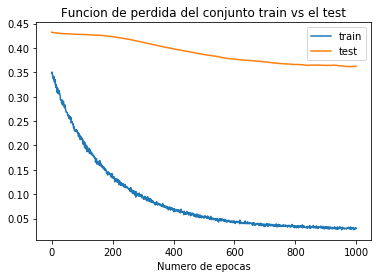

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Funcion de perdida del conjunto train vs el test")
plt.xlabel("Numero de epocas")
plt.show()


### Predecimos el test y lo graficamos con respecto al valor real

In [13]:
y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

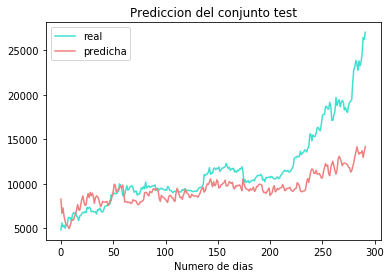

In [14]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

### Predecimos el train y lo graficamos con respecto al valor real

In [15]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

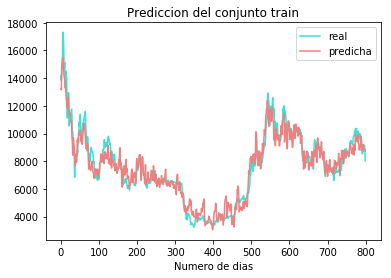

In [16]:
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")

In [17]:
 model.save('modelo_4-norm.h5')

In [18]:
#model=load_model("modelo_3-norm.h5")

In [19]:
# loss: 0.0235 - mae: 0.1674 - val_loss: 0.3506 - val_mae: 0.6643
# ventana: 3
# epocas: 1000
# tasa: 1e-6
# lambda: 10.0
# Dropout: 0.2
# entrenamiento: 800
# df: data_sin_tipocambio
#model.save('modelo_4-norm.h5')

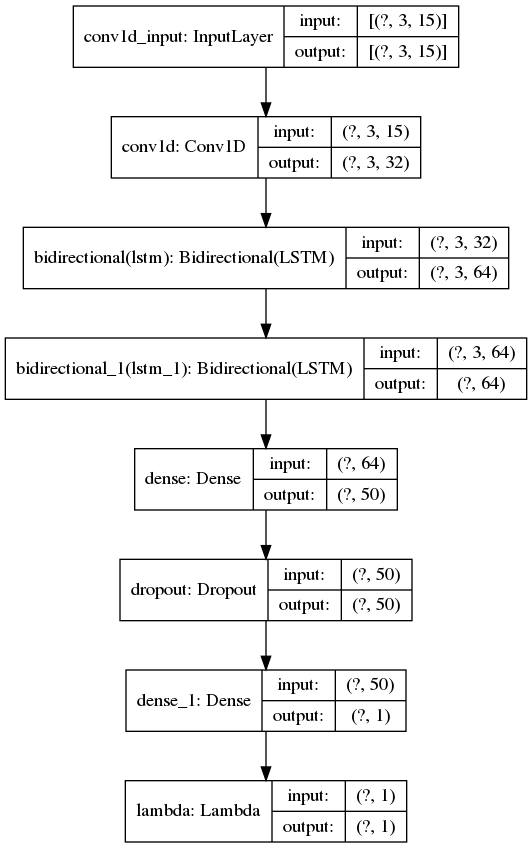

In [20]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)